In [11]:
import pandas as pd
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [23]:
# 데이터 불러오기
train_data = pd.read_csv("~/project/MIMIC-III/Baseline/overlap/All/overlap_All(1%)_train.csv")
test_data = pd.read_csv("~/project/MIMIC-III/Baseline/overlap/All/overlap_All(1%)_test.csv")

train_data.drop(["SUBJECT_ID","HADM_ID", "DOA", "TLOS", "ETHNICITY"], axis=1, inplace=True)
test_data.drop(["SUBJECT_ID","HADM_ID", "DOA", "TLOS", "ETHNICITY"], axis=1, inplace=True)

train_data = pd.get_dummies(train_data, columns=["GENDER"])
test_data = pd.get_dummies(test_data, columns=["GENDER"])

# train_data와 test_data의 칼럼을 맞추기 위해 차집합을 계산
missing_columns_in_test = set(train_data.columns) - set(test_data.columns)
missing_columns_in_train = set(test_data.columns) - set(train_data.columns)

# test_data에 train_data의 더미 변수를 추가하고 0으로 채워주기
for col in missing_columns_in_test:
    test_data[col] = 0

# train_data에 test_data의 더미 변수를 추가하고 0으로 채워주기
for col in missing_columns_in_train:
    train_data[col] = 0
    
####################################################################
# Down Sampling
# train 데이터의 레이블 비율 확인
train_labels = train_data['y']
label_counts = train_labels.value_counts()

# train 데이터의 레이블 비율이 1:1이 되도록 분할
class_0_data = train_data[train_data['y'] == 0]
class_1_data = train_data[train_data['y'] == 1]

# 레이블이 0인 데이터 중에서 샘플 개수가 적은 만큼만 선택
num_samples = min(label_counts[0], label_counts[1])
class_0_data = class_0_data.sample(num_samples, random_state=42)

# 레이블이 1인 데이터 중에서 샘플 개수가 적은 만큼만 선택
class_1_data = class_1_data.sample(num_samples, random_state=42)

# 선택한 데이터를 결합하여 최종 train 데이터 생성
train_data = pd.concat([class_0_data, class_1_data])
####################################################################


# Features와 Target 설정
X_train = train_data.drop('y', axis=1)
y_train = train_data['y']
X_test = test_data.drop('y', axis=1)

print("train shape\n",X_train.shape,"\n")
print("train shape\n",X_test.shape,"\n")

target = "y"
features = [f for f in train_data.columns if f not in [target]]

print("train value\n",train_data['y'].value_counts())
print("test value\n",test_data['y'].value_counts())

train shape
 (3442, 55) 

train shape
 (146, 55) 

train value
 0    1721
1    1721
Name: y, dtype: int64
test value
 0    117
1     29
Name: y, dtype: int64


In [24]:
# 로지스틱 회귀 모델 학습
def objective(trial):
    c = trial.suggest_float("c", 1e-8, 10.0, log=True)
    
    model = LogisticRegression(C=c, random_state=42)
    
    # Cross Validation을 통한 평가 지표 계산
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    return scores.mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, gc_after_trial=True)

[I 2023-08-26 12:08:31,392] A new study created in memory with name: no-name-55cfe579-8ae1-4005-9f89-7d1797cdcdb9
[I 2023-08-26 12:08:31,598] Trial 0 finished with value: 0.6437936982825613 and parameters: {'c': 0.024219279587839194}. Best is trial 0 with value: 0.6437936982825613.
[I 2023-08-26 12:08:31,794] Trial 1 finished with value: 0.5839869831747151 and parameters: {'c': 3.0790720089708827e-06}. Best is trial 0 with value: 0.6437936982825613.
[I 2023-08-26 12:08:32,068] Trial 2 finished with value: 0.6466855613425675 and parameters: {'c': 0.6888969839385675}. Best is trial 2 with value: 0.6466855613425675.
[I 2023-08-26 12:08:32,359] Trial 3 finished with value: 0.6444605854683495 and parameters: {'c': 0.0006293739552048873}. Best is trial 2 with value: 0.6466855613425675.
[I 2023-08-26 12:08:32,621] Trial 4 finished with value: 0.6438134084907462 and parameters: {'c': 0.001695043028714444}. Best is trial 2 with value: 0.6466855613425675.
[I 2023-08-26 12:08:32,809] Trial 5 fini

In [25]:
# 최적 하이퍼파라미터 확인
best_c = study.best_params["c"]

# 최적 모델 학습 및 평가
best_model = LogisticRegression(C=best_c, random_state=42)
best_model.fit(X_train, y_train)

LogisticRegression(C=0.6888969839385675, random_state=42)

Accuracy: 0.7054794520547946
Precision: 0.37037037037037035
Recall: 0.6896551724137931
F1-score: 0.48192771084337355


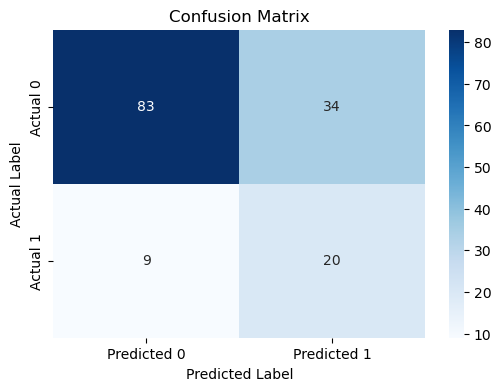

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.71      0.79       117
           1       0.37      0.69      0.48        29

    accuracy                           0.71       146
   macro avg       0.64      0.70      0.64       146
weighted avg       0.80      0.71      0.73       146



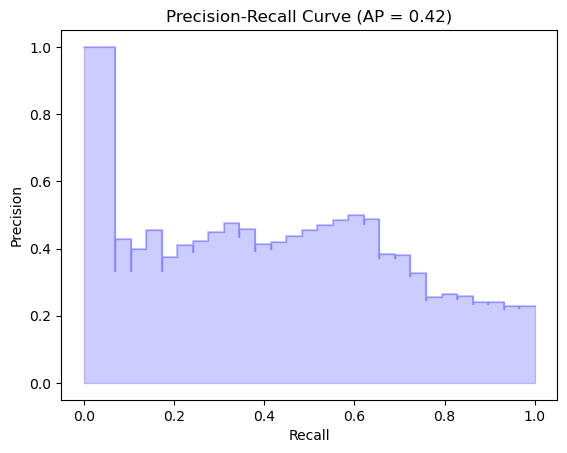

In [26]:
# Test 데이터로 모델 평가
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(test_data['y'], y_pred)
precision = precision_score(test_data['y'], y_pred)
recall = recall_score(test_data['y'], y_pred)
f1 = f1_score(test_data['y'], y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Confusion Matrix 계산
cm = confusion_matrix(test_data['y'], y_pred)

# Confusion Matrix 시각화
cm_df = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

# Classification Report 출력
print("Classification Report:")
print(classification_report(test_data['y'], y_pred))

# Precision-Recall Curve 계산 및 시각화
precision, recall, _ = precision_recall_curve(test_data['y'], best_model.predict_proba(X_test)[:, 1])
average_precision = auc(recall, precision)
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AP = {average_precision:.2f})')
plt.show()

# # Feature Importance 계산
# feature_importance = best_model.feature_importances_

# # Feature Importance 시각화
# plt.figure(figsize=(10, 6))
# sns.barplot(x=feature_importance, y=features)
# plt.title('Feature Importance')
# plt.xlabel('Importance')
# plt.ylabel('Feature')
# plt.show()